In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../Data/flight_dep_tree.csv")
df.shape
df.head(5)

,MONTH,DAY_OF_MONTH_sin,DAY_OF_MONTH_cos,DAY_OF_WEEK_sin,DAY_OF_WEEK_cos,CRS_ELAPSED_TIME,DISTANCE,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyVisibility,HourlyWindSpeed,CRS_DEP_TIME_sin,CRS_DEP_TIME_cos,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_DELAY
0,4,0.201299,0.97953,0.974928,-0.222521,168.0,1020.0,33.0,36.0,89.0,5.0,10.0,0.990389,-0.138309,0,1,62,-5.0
1,4,0.201299,0.97953,0.974928,-0.222521,160.0,1020.0,33.0,45.0,63.0,10.0,10.0,-0.785317,-0.619094,0,1,62,15.0
2,4,0.201299,0.97953,0.974928,-0.222521,299.0,2279.0,37.0,43.0,80.0,10.0,6.0,0.939991,-0.341200,0,4,14,-3.0
3,4,0.201299,0.97953,0.974928,-0.222521,300.0,2279.0,41.0,49.0,74.0,10.0,6.0,-0.460974,-0.887413,0,4,14,-3.0
4,4,0.201299,0.97953,0.974928,-0.222521,300.0,2279.0,41.0,45.0,86.0,10.0,7.0,-0.500000,0.866025,0,4,14,-6.0


In [3]:
X = df.drop(columns=["DEP_DELAY"])
y = df["DEP_DELAY"].values

In [4]:
# Chia dữ liệu train/test theo tỉ lệ 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (36124, 17), Test set: (9031, 17)


In [5]:
param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [6, 8, 10],
    'num_leaves': [31, 50, 70],
    'min_data_in_leaf': [20, 30, 50],
    'feature_fraction': [0.8, 1.0],
    'bagging_fraction': [0.8, 1.0]
}

lgbm = LGBMRegressor(random_state=42, n_jobs=-1)

grid = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)

In [6]:
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print(f"Best CV R² Score: {grid.best_score_:.4f}")

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

In [9]:
best_lgbm = grid.best_estimator_
y_pred = best_lgbm.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n LightGBM Performance:")
print(f"MAE   = {mae:.3f}")
print(f"RMSE  = {rmse:.3f}")

print("Predictions:", y_pred[:11])
print("Actuals:    ", y_test[:11])

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

 LightGBM Performance:
MAE   = 6.927
RMSE  = 9.430
Predictions: [-3.97240254 -3.76383162 -6.31739511  8.33749147  5.84599049  4.40404445
 -3.66607522  0.65777015  1.15202481 -0.13622693  3.06055669]
Actuals:     [  3.  -8.  -9.   5.   7.  -4. -10.  -6.   0.  -2.  29.]


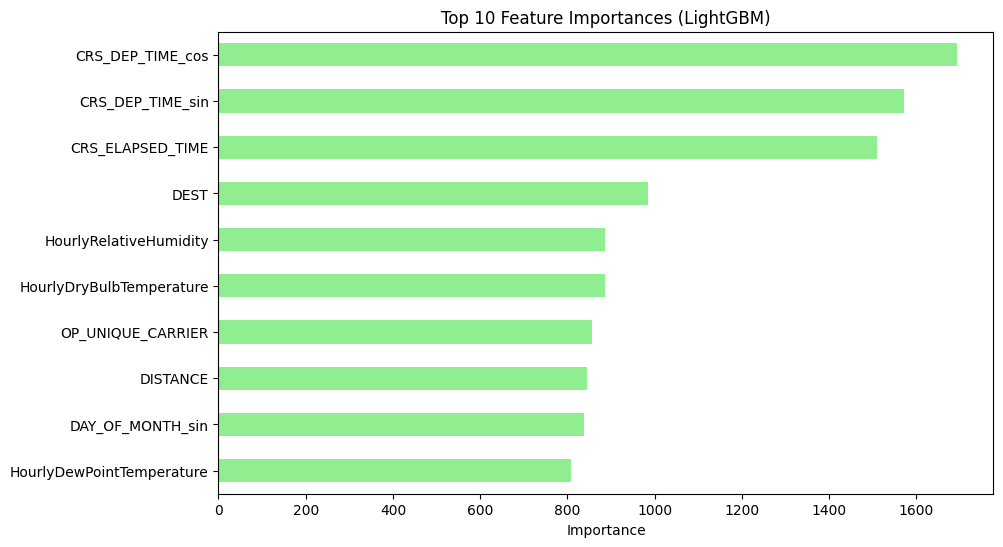

In [10]:
importances = pd.Series(best_lgbm.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances.head(10).plot(kind="barh", color="lightgreen")
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (LightGBM)")
plt.xlabel("Importance")
plt.show()